In [20]:
from flask import Flask
from flask import request
import werkzeug
import cv2
from PIL import Image
import mediapipe as mp
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Class containing Final Results for MediaPipe

In [21]:
class Results:
    
    cols = ["x","y","z","vis"]
    #TRAGULAR DATA
    trag_cols = ["x","y","z","vis"]
    trag_left_rows = ["left_ear","left_index","left_elbow","left_wrist"]
    trag_right_rows = ["right_ear","right_index","right_elbow","right_wrist"]
    tragular_left_coord = []
    tragular_right_coord = []
    
    #LUMBAR DATA
    lumbar_cols = ["x","y","z","vis"]
    lumbar_rows = ["left_index_world","right_index_world","left_index_hol","right_index_hol",
                  "left_wrist","right_wrist","left_elbow","right_elbow"]
    lumbar_neutral_coord = []
    lumbar_left_coord = []
    lumbar_right_coord = []
    
    #INTERMALLEOLAR DATA
    intermalleolar_rows = ["left_ankle_world","right_ankle_world","left_ankle_hol"
                           ,"right_ankle_hol","left_knee_hol","right_knee_hol"]
    intermalleolar_coord = []
    
    #CERVICAL DATA
    cervical_cols = ["x","y","z","vis"]
    cervical_left_coord = []
    cervical_neutral_coord = []
    cervical_right_coord = []
    
    #FLEXION DATA
    flexion_neutral_left_rows = ["left_shoulder_neutral_world","left_shoulder_neutral_norm",
                         "left_hip_neutral_world","left_hip_neutral_norm"]
    flexion_extension_left_rows = ["left_shoulder_extension_world","left_shoulder_extension_norm",
                         "left_hip_extension_world","left_hip_extension_norm"]
    flexion_neutral_right_rows = ["right_shoulder_neutral_world","right_shoulder_neutral_norm",
                         "right_hip_neutral_world","right_hip_neutral_norm"]
    flexion_extension_right_rows = ["right_shoulder_extension_world","right_shoulder_extension_norm",
                         "right_hip_extension_world","right_hip_extension_norm"]
    
    flexion_neutral_left_coord = []
    flexion_neutral_right_coord = []
    flexion_extension_left_coord = []
    flexion_extension_right_coord = []
    
    

In [22]:
def draw(annotated_image,results,mp_holistic):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    
    mp_drawing.draw_landmarks(
        annotated_image, 
        results.left_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS)
    
    mp_drawing.draw_landmarks(
        annotated_image, 
        results.right_hand_landmarks, 
        mp_holistic.HAND_CONNECTIONS)
    
    mp_drawing.draw_landmarks(
        annotated_image,
        results.face_landmarks,
        mp_holistic.FACEMESH_TESSELATION,
        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255), thickness=1, circle_radius=1),
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),thickness=1, circle_radius=1))
    
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.
        get_default_pose_landmarks_style())
    

In [23]:
#Function used to calculate relevant lumbar coordinates
def mp_pose_lumbar(side,file):
    
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode = True,model_complexity = 2, enable_segmentation=True,min_detection_confidence = 0.5)
    image = cv2.imread(file)
    results = pose.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255), thickness=5, circle_radius=6),
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
        thickness=5, circle_radius=5))
    mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    cv2.imwrite("lumbar.png",image)

    coordinate_list = [[results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].x,
                            results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].y,
                            results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].z,
                            results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.LEFT_INDEX].visibility],
                           [results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX].x,
                            results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX].y,
                            results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX].z,
                            results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_INDEX].visibility]]

    
    if(side == -1):
        Results.lumbar_left_coord = pd.DataFrame(coordinate_list,columns=Results.lumbar_cols)
        Results.lumbar_left_coord.index = Results.lumbar_rows
        print(Results.lumbar_left_coord)
    elif(side == 0):
        Results.lumbar_neutral_coord = pd.DataFrame(coordinate_list,columns=Results.lumbar_cols)
        Results.lumbar_neutral_coord.index = Results.lumbar_rows
        print(Results.lumbar_neutral_coord)
    else:
        Results.lumbar_right_coord = pd.DataFrame(coordinate_list,columns=Results.lumbar_cols)
        Results.lumbar_right_coord.index = Results.lumbar_rows
        print(Results.lumbar_right_coord)
    
    

# Functions for Measurements
    

In [24]:
#Function used to calculate the relevant tragular coordinates
def mp_pose_tragular(side,file):
    mp_holistic = mp.solutions.holistic 

    holistic = mp_holistic.Holistic(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=True,
        refine_face_landmarks=True)
    
    image = cv2.imread(file)
    results = holistic.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    annotated_image = image.copy()
    
    draw(annotated_image,results,mp_holistic)
    
    if(side == 0):
        cv2.imwrite("left_tragular_annotated.png",annotated_image)
        left_hand = results.left_hand_landmarks
        
        left_wrist_coord = [results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_WRIST].x,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_WRIST].y,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_WRIST].z,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_WRIST].visibility]
        
        left_elbow_coord = [results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_ELBOW].x,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_ELBOW].y,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_ELBOW].z,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_ELBOW].visibility]
        
        left_ear_coord = [results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].x,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].y,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].z,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_EAR].visibility]
        
        left_index_coord = [left_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].x,
                                       left_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].y,
                                       left_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].z,
                                       left_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].visibility]
        
        
        
        coordinate_list = [left_ear_coord,left_index_coord,left_elbow_coord,left_wrist_coord]
        
        Results.tragular_left_coord = pd.DataFrame(coordinate_list,columns=Results.trag_cols)
        Results.tragular_left_coord.index = Results.trag_left_rows
        print(Results.tragular_left_coord)
    else:
        cv2.imwrite("right_tragular_annotated.png",annotated_image)
        right_hand = results.right_hand_landmarks
        
        right_wrist_coord = [results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_WRIST].x,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_WRIST].y,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_WRIST].z,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_WRIST].visibility]
        
        right_elbow_coord = [results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ELBOW].x,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ELBOW].y,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ELBOW].z,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ELBOW].visibility]
        
        right_ear_coord = [results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_EAR].x,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_EAR].y,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_EAR].z,
                                        results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_EAR].visibility]
        
        right_index_coord = [right_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].x,
                                       right_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].y,
                                       right_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].z,
                                       right_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].visibility]
        
        
        coordinate_list = [right_ear_coord,right_index_coord,right_elbow_coord,right_wrist_coord]
        
        Results.tragular_right_coord = pd.DataFrame(coordinate_list,columns=Results.trag_cols)
        Results.tragular_right_coord.index = Results.trag_right_rows
        print(Results.tragular_right_coord)
    

In [25]:
def mp_lumbar_holistic(side, file):
    mp_holistic = mp.solutions.holistic 
    
    holistic = mp_holistic.Holistic(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=True,
        refine_face_landmarks=True)
    
    image = cv2.imread(file)
    results = holistic.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    annotated_image = image.copy()
    
    draw(annotated_image,results,mp_holistic)
    
    cv2.imwrite("lumbar.png",annotated_image)
    
    right_hand = results.right_hand_landmarks
    left_hand = results.left_hand_landmarks
    
    left_wrist_coord = [results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_WRIST].x,
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_WRIST].y,
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_WRIST].z,
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_WRIST].visibility]
        
    left_elbow_coord = [results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_ELBOW].x,
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_ELBOW].y,
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_ELBOW].z,
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_ELBOW].visibility]
        
    left_index_coord_hol = [left_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].x,
                                    left_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].y,
                                    left_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].z,
                                    left_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].visibility]
    
    left_index_coord_world = [results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_INDEX].x,
                                    results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_INDEX].y,
                                    results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_INDEX].z,
                                    results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_INDEX].visibility]
        
    right_wrist_coord = [results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_WRIST].x,
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_WRIST].y,
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_WRIST].z,
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_WRIST].visibility]
        
    right_elbow_coord = [results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ELBOW].x,
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ELBOW].y,
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ELBOW].z,
                                    results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_ELBOW].visibility]
        
    right_index_coord_hol = [right_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].x,
                                    right_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].y,
                                    right_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].z,
                                    right_hand.landmark[mp_holistic.HandLandmark.INDEX_FINGER_TIP].visibility]
        
    right_index_coord_world =  [results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_INDEX].x,
                                    results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_INDEX].y,
                                    results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_INDEX].z,
                                    results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_INDEX].visibility]

    coordinate_list = [left_index_coord_world, right_index_coord_world, left_index_coord_hol, 
                       right_index_coord_hol,left_wrist_coord, right_wrist_coord, left_elbow_coord, right_elbow_coord]

    
    if(side == -1):
        Results.lumbar_left_coord = pd.DataFrame(coordinate_list,columns=Results.lumbar_cols)
        Results.lumbar_left_coord.index = Results.lumbar_rows
        print(Results.lumbar_left_coord)
        
    elif(side == 0):
        Results.lumbar_neutral_coord = pd.DataFrame(coordinate_list,columns=Results.lumbar_cols)
        Results.lumbar_neutral_coord.index = Results.lumbar_rows
        print(Results.lumbar_neutral_coord)
        
    else:
        Results.lumbar_right_coord = pd.DataFrame(coordinate_list,columns=Results.lumbar_cols)
        Results.lumbar_right_coord.index = Results.lumbar_rows
        print(Results.lumbar_right_coord)
    
    

In [26]:
def mp_pose_intermalleolar(file):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode = True,model_complexity = 2, enable_segmentation=True,min_detection_confidence = 0.5)
    image = cv2.imread(file)
    results = pose.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255), thickness=5, circle_radius=6),
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
        thickness=5, circle_radius=5))

    cv2.imwrite("intermalleolar_annotated.png",image)
    
    left_ankle_world = results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE]
    right_ankle_world = results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE]
    left_ankle_norm = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_ANKLE]
    right_ankle_norm = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_ANKLE]
    left_knee_norm = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_KNEE]
    right_knee_norm = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_KNEE]
    
    coordinate_list = [[left_ankle_world.x,
                        left_ankle_world.y,
                        left_ankle_world.z,
                        left_ankle_world.visibility],
                       
                        [right_ankle_world.x,
                         right_ankle_world.y,
                         right_ankle_world.z,
                         right_ankle_world.visibility],
                       
                        [left_ankle_norm.x,
                         left_ankle_norm.y,
                         left_ankle_norm.z,
                         left_ankle_norm.visibility],
                       
                        [right_ankle_norm.x,
                         right_ankle_norm.y,
                         right_ankle_norm.z,
                         right_ankle_norm.visibility],
                      
                        [left_knee_norm.x,
                         left_knee_norm.y,
                         left_knee_norm.z,
                         left_knee_norm.visibility],
                       
                        [right_knee_norm.x,
                         right_knee_norm.y,
                         right_knee_norm.z,
                         right_knee_norm.visibility]]
    
    Results.intermalleolar_coord = pd.DataFrame(coordinate_list,columns=Results.cols)
    Results.intermalleolar_coord.index = Results.intermalleolar_rows
    

In [27]:
def mp_pose_cervical(file,side):
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode = True,model_complexity = 2, enable_segmentation=True,min_detection_confidence = 0.5)
    image = cv2.imread(file)
    results = pose.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255), thickness=50, circle_radius=10),
        connection_drawing_spec=mp_drawing.DrawingSpec(color=(49,125,237),
        thickness=50, circle_radius=10))
    mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
    
    
    nose_world = results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.NOSE]
    right_ear_world = results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR]
    left_ear_world = results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR]
    nose_norm = results.pose_world_landmarks.landmark[mp_pose.PoseLandmark.NOSE]
    right_ear_norm = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_EAR]
    left_ear_norm = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_EAR]

    if side == -1:
        cv2.imwrite("left_cervical.png",image)
        coordinate_list = [[nose_world.x, nose_world.y, nose_world.z, nose_world.visibility],
                            
                           [right_ear_world.x, right_ear_world.y, right_ear_world.z, right_ear_world.visibility],
                            
                           [nose_norm.x, nose_norm.y, nose_norm.z, nose_norm.visibility],
                           
                           [right_ear_norm.x, right_ear_norm.y, right_ear_norm.z, right_ear_norm.visibility]]
            
        Results.cervical_left_coord = pd.DataFrame(coordinate_list,columns=Results.cols)
        Results.cervical_left_coord.index = ["left_nose_world_coordinates", "right_ear_world_coordinates",
                                            "left_nose_norm_coordinates","right_ear_norm_coordinates"]
        print(Results.cervical_left_coord)
    
    elif side == 0:
        cv2.imwrite("neutral_cervical.png",image)
        coordinate_list = [[nose_world.x, nose_world.y, nose_world.z, nose_world.visibility],
                            
                           [right_ear_world.x, right_ear_world.y, right_ear_world.z, right_ear_world.visibility],
                           
                           [left_ear_world.x, left_ear_world.y, left_ear_world.z, left_ear_world.visibility],
                            
                           [nose_norm.x, nose_norm.y, nose_norm.z, nose_norm.visibility],
                           
                           [right_ear_norm.x, right_ear_norm.y, right_ear_norm.z, right_ear_norm.visibility],
                          
                           [left_ear_norm.x, left_ear_norm.y, left_ear_norm.z, left_ear_norm.visibility]]
        
        Results.cervical_neutral_coord = pd.DataFrame(coordinate_list,columns=Results.cols)
        Results.cervical_neutral_coord.index = ["neutral_nose_world_coordinates","right_ear_world_coordinates",
                                               "left_ear_world_coordinates","nuetral_nose_norm_coordinates",
                                                "right_ear_norm_coordinates","left_ear_norm_coordinates"]
        print(Results.cervical_neutral_coord)
    else:
        cv2.imwrite("right_cervical.png",image)
        coordinate_list = [[nose_world.x, nose_world.y, nose_world.z, nose_world.visibility],
                            
                           [left_ear_world.x, left_ear_world.y, left_ear_world.z, left_ear_world.visibility],
                            
                           [nose_norm.x, nose_norm.y, nose_norm.z, nose_norm.visibility],
                           
                           [left_ear_norm.x, left_ear_norm.y, left_ear_norm.z, left_ear_norm.visibility]]
    
        Results.cervical_right_coord = pd.DataFrame(coordinate_list,columns=Results.cols)
        Results.cervical_right_coord.index = ["right_nose_world_coordinates", "left_ear_world_coordinates",
                                            "right_nose_norm_coordinates","left_ear_norm_coordinates"]
        print(Results.cervical_right_coord)
        
        
    
    
    
    

In [28]:
def mp_pose_flexion(file,side):
    
    mp_holistic = mp.solutions.holistic 
    
    holistic = mp_holistic.Holistic(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=True,
        refine_face_landmarks=True)
    
    image = cv2.imread(file)
    results = holistic.process(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    annotated_image = image.copy()
    
    draw(annotated_image,results,mp_holistic)
    cv2.imwrite("flexion.png",annotated_image)
    coordinate_list = []
    
    
    if side == -1 or side == 0:
        
        left_shoulder_world = results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_SHOULDER]
        left_shoulder_norm = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_SHOULDER]
        left_hip_world = results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_HIP]
        left_hip_norm = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_HIP]
        
        coordinate_list = [[left_shoulder_world.x,left_shoulder_world.y,
                         left_shoulder_world.z,left_shoulder_world.visibility],
                         
                         [left_shoulder_norm.x,left_shoulder_norm.y,
                         left_shoulder_norm.z,left_shoulder_norm.visibility],
                        
                        [left_hip_world.x,left_hip_world.y,
                         left_hip_world.z,left_hip_world.visibility],
                        
                        [left_hip_norm.x,left_hip_norm.y,
                         left_hip_norm.z,left_hip_norm.visibility]]
        if side == -1:
            Results.flexion_neutral_left_coord = pd.DataFrame(coordinate_list,columns=Results.cols)
            Results.flexion_neutral_left_coord.index = Results.flexion_neutral_left_rows
            print(Results.flexion_neutral_left_coord)
        else:
            Results.flexion_extension_left_coord = pd.DataFrame(coordinate_list,columns=Results.cols)
            Results.flexion_extension_left_coord.index = Results.flexion_extension_left_rows
            print(Results.flexion_extension_left_coord)
        
    else:
        
        right_shoulder_world = results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_SHOULDER]
        right_shoulder_norm = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_SHOULDER]
        right_hip_world = results.pose_world_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_HIP]
        right_hip_norm = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_HIP]
        
        coordinate_list = [[right_shoulder_world.x, right_shoulder_world.y, 
                            right_shoulder_world.z,right_shoulder_world.visibility],
                         
                         [right_shoulder_norm.x,right_shoulder_norm.y,
                         right_shoulder_norm.z,right_shoulder_norm.visibility],
                        
                        [right_hip_world.x, right_hip_world.y,
                         right_hip_world.z, right_hip_world.visibility],
                        
                        [right_hip_norm.x,right_hip_norm.y,
                         right_hip_norm.z,right_hip_norm.visibility]]
        
        if side == 1:
            Results.flexion_neutral_right_coord = pd.DataFrame(coordinate_list,columns=Results.cols)
            Results.flexion_neutral_right_coord.index = Results.flexion_neutral_right_rows
            print(Results.flexion_neutral_right_coord)
        else:
            Results.flexion_extension_right_coord = pd.DataFrame(coordinate_list,columns=Results.cols)
            Results.flexion_extension_right_coord.index = Results.flexion_extension_right_rows
            print(Results.flexion_extension_right_coord)
        

# Server Code

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://138.38.220.215:5000/ (Press CTRL+C to quit)
138.38.214.43 - - [27/Jul/2022 14:51:34] "POST /debug HTTP/1.1" 200 -


TRAGULAR CONNECTED

Received image file name: right_tragular.jpg


138.38.214.43 - - [27/Jul/2022 14:51:51] "POST /tragularRight HTTP/1.1" 200 -


                    x         y         z       vis
right_ear    0.443717  0.471191 -0.285030  0.998905
right_index  0.327886  0.516884 -0.021389  0.000000
right_elbow  0.583639  0.567388 -0.616750  0.994028
right_wrist  0.443647  0.510210 -0.682926  0.879279

Successful upload

Received image file name: left_tragular.jpg


138.38.214.43 - - [27/Jul/2022 14:51:58] "POST /tragularLeft HTTP/1.1" 200 -


                   x         y         z       vis
left_ear    0.457414  0.475096 -0.295187  0.999619
left_index  0.599036  0.551729 -0.025831  0.000000
left_elbow  0.270581  0.637819 -0.326727  0.464127
left_wrist  0.447239  0.543157 -0.096888  0.437590

Successful upload


138.38.214.43 - - [27/Jul/2022 14:52:00] "POST /debug HTTP/1.1" 200 -


LUMBAR CONNECTED

Received image file name: neutral_lumbar.jpg


138.38.214.43 - - [27/Jul/2022 14:52:56] "POST /lumbarNeutral HTTP/1.1" 200 -


                          x         y         z       vis
left_index_world   0.237542  0.072205 -0.076985  0.989925
right_index_world -0.187947  0.044256 -0.224293  0.994603
left_index_hol     0.638763  0.683424 -0.020545  0.000000
right_index_hol    0.362609  0.689599 -0.019183  0.000000
left_wrist         0.629367  0.618978 -0.298275  0.993658
right_wrist        0.368117  0.623895 -0.402394  0.997322
left_elbow         0.609082  0.522081 -0.153827  0.989746
right_elbow        0.384055  0.526739 -0.216594  0.993360

Successful upload

Received image file name: right_lumbar.jpg


138.38.214.43 - - [27/Jul/2022 14:53:02] "POST /lumbarRight HTTP/1.1" 200 -


                          x         y         z       vis
left_index_world   0.264558 -0.038304 -0.227798  0.986838
right_index_world -0.194756  0.175178 -0.343441  0.994041
left_index_hol     0.666298  0.616864 -0.013926  0.000000
right_index_hol    0.382436  0.732651  0.006601  0.000000
left_wrist         0.633807  0.556806 -0.584538  0.992641
right_wrist        0.374175  0.674250 -0.613526  0.997453
left_elbow         0.566756  0.475499 -0.420265  0.990359
right_elbow        0.352153  0.577979 -0.394498  0.991924

Successful upload

Received image file name: left_lumbar.jpg


138.38.214.43 - - [27/Jul/2022 14:53:08] "POST /lumbarLeft HTTP/1.1" 200 -


                          x         y         z       vis
left_index_world   0.240499  0.245874 -0.157463  0.996643
right_index_world -0.153710 -0.053704 -0.272541  0.996000
left_index_hol     0.564450  0.730621 -0.017922  0.000000
right_index_hol    0.286099  0.614792 -0.007858  0.000000
left_wrist         0.567613  0.675580 -0.464744  0.998196
right_wrist        0.307228  0.551346 -0.512126  0.998028
left_elbow         0.577982  0.582702 -0.283351  0.995498
right_elbow        0.351972  0.459833 -0.363980  0.995340

Successful upload


138.38.214.43 - - [27/Jul/2022 14:53:19] "POST /debug HTTP/1.1" 200 -


INTERMALLEOLAR CONNECTED

Received image file name: intermalleolar.jpg


138.38.214.43 - - [27/Jul/2022 14:53:42] "POST /intermalleolar HTTP/1.1" 200 -



Successful upload


138.38.214.43 - - [27/Jul/2022 14:53:48] "POST /debug HTTP/1.1" 200 -


CERVICAL CONNECTED

Received image file name: neutral_cervical.jpg


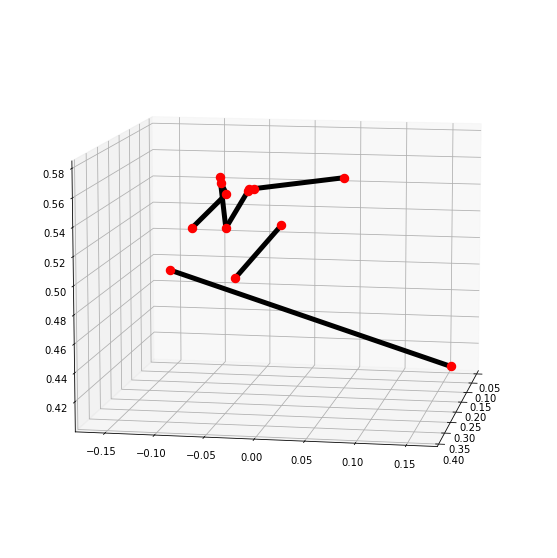

138.38.214.43 - - [27/Jul/2022 14:55:12] "POST /cervicalNeutral HTTP/1.1" 200 -


                                       x         y         z       vis
neutral_nose_world_coordinates -0.034278 -0.538608 -0.375236  0.999280
right_ear_world_coordinates    -0.095429 -0.523360 -0.238152  0.997801
left_ear_world_coordinates      0.063788 -0.562624 -0.245972  0.999018
nuetral_nose_norm_coordinates  -0.034278 -0.538608 -0.375236  0.999280
right_ear_norm_coordinates      0.382934  0.463494 -0.927354  0.997801
left_ear_norm_coordinates       0.603616  0.465913 -0.933058  0.999018

Successful upload

Received image file name: right_cervical.jpg


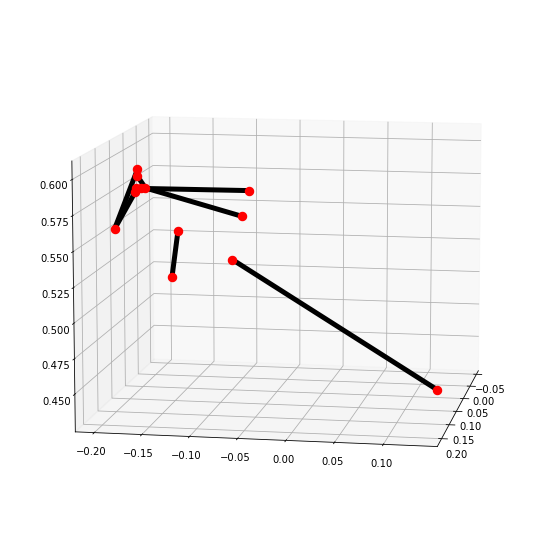

138.38.214.43 - - [27/Jul/2022 14:55:19] "POST /cervicalRight HTTP/1.1" 200 -


                                     x         y         z       vis
right_nose_world_coordinates -0.196222 -0.557385 -0.162234  0.995615
left_ear_world_coordinates   -0.042393 -0.593089 -0.208733  0.998671
right_nose_norm_coordinates  -0.196222 -0.557385 -0.162234  0.995615
left_ear_norm_coordinates     0.442921  0.480827 -0.556111  0.998671

Successful upload

Received image file name: left_cervical.jpg


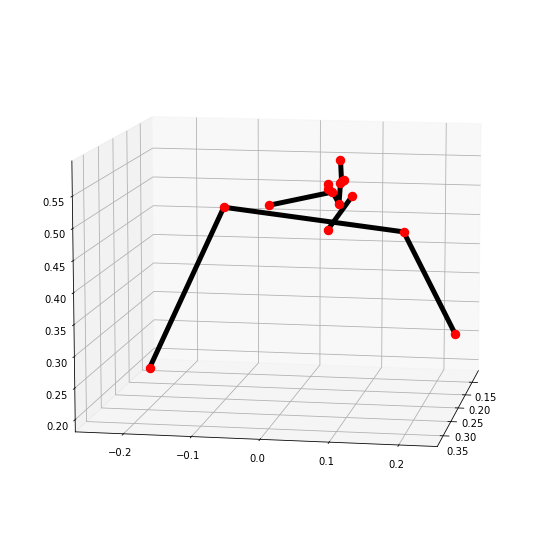

138.38.214.43 - - [27/Jul/2022 14:55:29] "POST /cervicalLeft HTTP/1.1" 200 -


                                    x         y         z       vis
left_nose_world_coordinates  0.096270 -0.531547 -0.328651  0.996933
right_ear_world_coordinates -0.008801 -0.523361 -0.318827  0.994806
left_nose_norm_coordinates   0.096270 -0.531547 -0.328651  0.996933
right_ear_norm_coordinates   0.511661  0.512945 -0.985615  0.994806

Successful upload


138.38.214.43 - - [27/Jul/2022 14:55:38] "POST /debug HTTP/1.1" 200 -


LUMBAR FLEXION CONNECTED

Received image file name: right_flexion_neutral.jpg


138.38.214.43 - - [27/Jul/2022 14:56:11] "POST /flexionRightNeutral HTTP/1.1" 200 -


                                     x         y         z       vis
right_shoulder_neutral_world  0.018716 -0.499601 -0.202627  0.999992
right_shoulder_neutral_norm   0.469396  0.456991 -0.484892  0.999992
right_hip_neutral_world      -0.004516 -0.000462 -0.117937  0.999994
right_hip_neutral_norm        0.463999  0.641232 -0.191253  0.999994

Successful upload

Received image file name: right_flexion_extension.jpg


138.38.214.43 - - [27/Jul/2022 14:56:16] "POST /flexionRightExtension HTTP/1.1" 200 -


                                       x         y         z       vis
right_shoulder_extension_world  0.392449 -0.256184 -0.215185  0.999994
right_shoulder_extension_norm   0.605866  0.535415 -0.515814  0.999994
right_hip_extension_world       0.012371  0.011987 -0.115535  0.999978
right_hip_extension_norm        0.405243  0.624252 -0.187436  0.999978

Successful upload

Received image file name: left_flexion_neutral.jpg


138.38.214.43 - - [27/Jul/2022 14:56:22] "POST /flexionLeftNeutral HTTP/1.1" 200 -


                                    x         y         z       vis
left_shoulder_neutral_world -0.018263 -0.397774 -0.301276  0.999998
left_shoulder_neutral_norm   0.501734  0.444273 -0.527072  0.999998
left_hip_neutral_world       0.002635  0.010872 -0.071450  0.999979
left_hip_neutral_norm        0.506649  0.627767 -0.175964  0.999979

Successful upload

Received image file name: left_flexion_extension.jpg


138.38.214.43 - - [27/Jul/2022 14:56:27] "POST /flexionLeftExtension HTTP/1.1" 200 -


                                      x         y         z       vis
left_shoulder_extension_world -0.317487 -0.174668 -0.306597  0.999990
left_shoulder_extension_norm   0.364425  0.501281 -0.557332  0.999990
left_hip_extension_world       0.018332  0.021952 -0.075742  0.999923
left_hip_extension_norm        0.560387  0.595500 -0.187866  0.999923

Successful upload


138.38.214.43 - - [27/Jul/2022 14:57:36] "POST /debug HTTP/1.1" 200 -


CERVICAL CONNECTED


In [34]:
app = Flask(__name__)

@app.route("/")
def showHomePage():
    return "This is home page"

@app.route("/debug",methods=["POST"])
def debug():
    text = request.form["sample"]
    print(text)
    return "received"

####POSTING RELEVANT IMAGES TO SERVER###

@app.route("/tragularLeft",methods=["POST"])
def tragularLeft():
    imageFile = request.files['leftTragular']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_tragular(0,filename)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/tragularRight",methods=["POST"])
def tragularRight():
    imageFile = request.files['rightTragular']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_tragular(1,filename)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/lumbarLeft",methods=["POST"])
def lumbarLeft():
    imageFile = request.files['leftLumbar']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_lumbar_holistic(-1,filename)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/lumbarNeutral",methods=["POST"])
def lumbarNeutral():
    imageFile = request.files['neutralLumbar']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_lumbar_holistic(0,filename)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/lumbarRight",methods=["POST"])
def lumbarRight():
    imageFile = request.files['rightLumbar']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_lumbar_holistic(1,filename)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/intermalleolar",methods=["POST"])
def intermalleolar():
    imageFile = request.files['intermalleolar']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_intermalleolar(filename)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/cervicalLeft",methods=["POST"])
def cervicalLeft():
    imageFile = request.files['leftCervical']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_cervical(filename,-1)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/cervicalNeutral",methods=["POST"])
def cervicalNeutral():
    imageFile = request.files['neutralCervical']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_cervical(filename,0)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/cervicalRight",methods=["POST"])
def cervicalRight():
    imageFile = request.files['rightCervical']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_cervical(filename,1)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/flexionLeftNeutral",methods=["POST"])
def flexionLeftNeutral():
    imageFile = request.files['leftFlexionNeutral']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_flexion(filename,-1)
    print("\nSuccessful upload")
    return "Image uploaded successfully"


@app.route("/flexionLeftExtension",methods=["POST"])
def flexionLeftExtension():
    imageFile = request.files['leftFlexionExtension']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_flexion(filename,0)
    print("\nSuccessful upload")
    return "Image uploaded successfully"


@app.route("/flexionRightNeutral",methods=["POST"])
def flexionRightNeutral():
    imageFile = request.files['rightFlexionNeutral']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_flexion(filename,1)
    print("\nSuccessful upload")
    return "Image uploaded successfully"

@app.route("/flexionRightExtension",methods=["POST"])
def flexionRightExtension():
    imageFile = request.files['rightFlexionExtension']
    filename = werkzeug.utils.secure_filename(imageFile.filename)
    print("\nReceived image file name: "+imageFile.filename)
    imageFile.save(filename)
    mp_pose_flexion(filename,2)
    print("\nSuccessful upload")
    return "Image uploaded successfully"
    
    

if __name__ == "__main__":
    app.run(host="0.0.0.0")

In [11]:
Results.flexion_neutral_right_coord


,x,y,z,vis
right_shoulder_neutral_world,0.018716,-0.499601,-0.202627,0.999992
right_shoulder_neutral_norm,0.469396,0.456991,-0.484892,0.999992
right_hip_neutral_world,-0.004516,-0.000462,-0.117937,0.999994
right_hip_neutral_norm,0.463999,0.641232,-0.191253,0.999994


In [12]:
Results.intermalleolar_coord

,x,y,z,vis
left_ankle_world,0.584046,0.584443,0.036896,0.976729
right_ankle_world,-0.736873,0.360075,0.008429,0.993300
left_ankle_hol,0.847942,0.799248,0.043219,0.976729
right_ankle_hol,0.099740,0.717441,-0.061673,0.993300
left_knee_hol,0.705926,0.692393,-0.152538,0.994960
right_knee_hol,0.286575,0.643894,-0.163435,0.997133


In [13]:
Results.cervical_left_coord

,x,y,z,vis
left_nose_world_coordinates,0.096270,-0.531547,-0.328651,0.996933
right_ear_world_coordinates,-0.008801,-0.523361,-0.318827,0.994806
left_nose_norm_coordinates,0.096270,-0.531547,-0.328651,0.996933
right_ear_norm_coordinates,0.511661,0.512945,-0.985615,0.994806


In [14]:
def distance(point1,point2):
    return math.sqrt(pow((point1[0]-point2[0]),2)+pow((point1[1]-point2[1]),2))

In [15]:
Results.tragular_left_coord

,x,y,z,vis
left_ear,0.457414,0.475096,-0.295187,0.999619
left_index,0.599036,0.551729,-0.025831,0.000000
left_elbow,0.270581,0.637819,-0.326727,0.464127
left_wrist,0.447239,0.543157,-0.096888,0.437590


In [16]:
Results.tragular_left_coord
left_results = Results.tragular_left_coord.values.tolist()
distanceIndexWrist = distance(left_results[1],left_results[3])
distanceIndexWrist
ratioIW = 16/distanceIndexWrist
ratioIW

distanceIndexEar = distance(left_results[1],left_results[0])
print(distanceIndexEar*ratioIW)

16.945737996154527


In [33]:
writer = pd.ExcelWriter('Participant_No4_MediaPipe.xlsx',engine='xlsxwriter')
workbook=writer.book

Results.tragular_left_coord.to_excel(writer,sheet_name='Tragular Result',startrow=1 , startcol=0)

Results.tragular_right_coord.to_excel(writer,sheet_name='Tragular Result',startrow=len(Results.tragular_left_coord)+3,startcol=0)

Results.lumbar_neutral_coord.to_excel(writer,sheet_name="Lumbar Result",startrow=1,startcol=0)
Results.lumbar_left_coord.to_excel(writer,sheet_name="Lumbar Result",startrow=10,startcol=0)
Results.lumbar_right_coord.to_excel(writer,sheet_name="Lumbar Result",startrow=19,startcol=0)

Results.intermalleolar_coord.to_excel(writer,sheet_name="Intermalleolar Result",startrow=1,startcol=0)

Results.cervical_neutral_coord.to_excel(writer,sheet_name="Cervical Result",startrow=1,startcol=0)
Results.cervical_left_coord.to_excel(writer,sheet_name="Cervical Result",startrow=8,startcol=0)
Results.cervical_right_coord.to_excel(writer,sheet_name="Cervical Result",startrow=13,startcol=0)
    
Results.flexion_neutral_left_coord.to_excel(writer,sheet_name="Flexion Result",startrow=1,startcol=0)
Results.flexion_extension_left_coord.to_excel(writer,sheet_name="Flexion Result",startrow=6,startcol=0)
Results.flexion_neutral_right_coord.to_excel(writer,sheet_name="Flexion Result",startrow=11,startcol=0)
Results.flexion_extension_right_coord.to_excel(writer,sheet_name="Flexion Result",startrow=16,startcol=0)

writer.save()






In [18]:
#tragular left: 17.5
#tragular right: 17.5

#Neutral Lumbar right: 64
#Neutral Lumbar Left: 67

#Extension Lumbar Right: 47
#Extension Lumbar Left: 52

#Intermalleolar: 109

#Cervical Neutral: 5 degrees
#Cervical Right: 60 degrees
#Cervical Left: 35 degrees

#Lumbar Flexion: 3 cm

#16
#42
#41